In [1]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "torch"
import keras
keras.utils.set_random_seed(812)


In [2]:
#create synthetic time series random uniform integers
n = 1000
time = np.arange(0, n, 1)
data = np.random.randint(0, 6, n)

In [3]:
#select random timewindows of length 5 without overlapping
motif_indexes = []
k = 100
p = 5
# available_starts = list(range(n - p))

# start = 0
# for i in range(k):
#     if not available_starts:
#         break
#     start = np.random.choice(available_starts)
#     motif_indexes.append(start)
#     available_starts = [idx for idx in available_starts if not idx in range(start - p, start + p)]

# motif_indexes = sorted(motif_indexes)

In [4]:
motif_indexes = []

start = 0
while len(motif_indexes) < k:
    if len(motif_indexes) % 2 == 0:
        start += p
    else:
        start += 2 * p
    motif_indexes.append(start)

motif_indexes = sorted(motif_indexes)
#normalize the data
motif_indexes = [idx / n for idx in motif_indexes]
motif_indexes


[0.005,
 0.015,
 0.02,
 0.03,
 0.035,
 0.045,
 0.05,
 0.06,
 0.065,
 0.075,
 0.08,
 0.09,
 0.095,
 0.105,
 0.11,
 0.12,
 0.125,
 0.135,
 0.14,
 0.15,
 0.155,
 0.165,
 0.17,
 0.18,
 0.185,
 0.195,
 0.2,
 0.21,
 0.215,
 0.225,
 0.23,
 0.24,
 0.245,
 0.255,
 0.26,
 0.27,
 0.275,
 0.285,
 0.29,
 0.3,
 0.305,
 0.315,
 0.32,
 0.33,
 0.335,
 0.345,
 0.35,
 0.36,
 0.365,
 0.375,
 0.38,
 0.39,
 0.395,
 0.405,
 0.41,
 0.42,
 0.425,
 0.435,
 0.44,
 0.45,
 0.455,
 0.465,
 0.47,
 0.48,
 0.485,
 0.495,
 0.5,
 0.51,
 0.515,
 0.525,
 0.53,
 0.54,
 0.545,
 0.555,
 0.56,
 0.57,
 0.575,
 0.585,
 0.59,
 0.6,
 0.605,
 0.615,
 0.62,
 0.63,
 0.635,
 0.645,
 0.65,
 0.66,
 0.665,
 0.675,
 0.68,
 0.69,
 0.695,
 0.705,
 0.71,
 0.72,
 0.725,
 0.735,
 0.74,
 0.75]

In [5]:
#motif_pattern = [1,3,5,3,1]
#change the values of the time series in the selected timewindows to the motif pattern
#for idx in motif_indexes:
#    data[idx:idx+p] = motif_pattern

#data

In [6]:
def split_sequence(sequence):
    X, y = list(), list()
    for end_ix in range(1,len(sequence)):
        seq_x, seq_y = sequence[:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return X, np.array(y)

In [7]:
X, y = split_sequence(motif_indexes)
for i in range(len(X)):
 print(X[i], y[i])



[0.005] 0.015
[0.005, 0.015] 0.02
[0.005, 0.015, 0.02] 0.03
[0.005, 0.015, 0.02, 0.03] 0.035
[0.005, 0.015, 0.02, 0.03, 0.035] 0.045
[0.005, 0.015, 0.02, 0.03, 0.035, 0.045] 0.05
[0.005, 0.015, 0.02, 0.03, 0.035, 0.045, 0.05] 0.06
[0.005, 0.015, 0.02, 0.03, 0.035, 0.045, 0.05, 0.06] 0.065
[0.005, 0.015, 0.02, 0.03, 0.035, 0.045, 0.05, 0.06, 0.065] 0.075
[0.005, 0.015, 0.02, 0.03, 0.035, 0.045, 0.05, 0.06, 0.065, 0.075] 0.08
[0.005, 0.015, 0.02, 0.03, 0.035, 0.045, 0.05, 0.06, 0.065, 0.075, 0.08] 0.09
[0.005, 0.015, 0.02, 0.03, 0.035, 0.045, 0.05, 0.06, 0.065, 0.075, 0.08, 0.09] 0.095
[0.005, 0.015, 0.02, 0.03, 0.035, 0.045, 0.05, 0.06, 0.065, 0.075, 0.08, 0.09, 0.095] 0.105
[0.005, 0.015, 0.02, 0.03, 0.035, 0.045, 0.05, 0.06, 0.065, 0.075, 0.08, 0.09, 0.095, 0.105] 0.11
[0.005, 0.015, 0.02, 0.03, 0.035, 0.045, 0.05, 0.06, 0.065, 0.075, 0.08, 0.09, 0.095, 0.105, 0.11] 0.12
[0.005, 0.015, 0.02, 0.03, 0.035, 0.045, 0.05, 0.06, 0.065, 0.075, 0.08, 0.09, 0.095, 0.105, 0.11, 0.12] 0.125
[0.0

In [8]:
#pad sequences putting zeros at the beginning
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X,  maxlen=10, padding='pre', truncating='pre', value=-1, dtype=float)
X[-1]

array([0.675, 0.68 , 0.69 , 0.695, 0.705, 0.71 , 0.72 , 0.725, 0.735,
       0.74 ])

In [9]:
#train validation test split
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#reshape input to be [samples, time steps, features]
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#X_train.shape

In [10]:
#train are the first 80% of the X
X_train = X[:int(0.8*len(X))]
X_test = X[int(0.8*len(X)):]
y_train = y[:int(0.8*len(y))]
y_test = y[int(0.8*len(y)):]

#reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1], 1))

X_train.shape

(79, 10, 1)

In [11]:
y_train.shape

(79,)

In [12]:
#train lstm
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Masking
from keras import Input

def create_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(Masking(mask_value=-1))
    model.add(LSTM(units=32, activation='tanh', return_sequences=True))
    model.add(LSTM(units=64, activation='tanh', return_sequences=True))
    model.add(LSTM(units=32, activation='tanh', return_sequences=False))
    model.add(Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01,0.001])
    model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae'])
    return model

In [13]:
import keras_tuner as kt
from keras.callbacks import EarlyStopping


tuner= kt.RandomSearch(
        create_model,
        objective='mae',
        max_trials=10,
        executions_per_trial=3
        )

tuner.search(
        x=X_train,
        y=y_train,
        epochs=100,
        batch_size=1,
        validation_data=(X_test,y_test),
        callbacks=[EarlyStopping('val_loss', patience=5)]
        )


Trial 2 Complete [00h 00m 59s]
mae: 0.0031409598886966705

Best mae So Far: 0.0031409598886966705
Total elapsed time: 00h 01m 47s


In [14]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,633 (162.63 KB)

 Trainable params: 41,633 (162.63 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
tuner.results_summary()


Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="mae", direction="min")

Trial 01 summary
Hyperparameters:
learning_rate: 0.001
Score: 0.0031409598886966705

Trial 00 summary
Hyperparameters:
learning_rate: 0.01
Score: 0.010090797208249569


In [16]:
#create a test to predict 1 sample
test = np.reshape(X_test[0], (1, X_test[0].shape[0], 1))

print(test)
#predict the next value
best_model.predict(test)


[[[0.53 ]
  [0.54 ]
  [0.545]
  [0.555]
  [0.56 ]
  [0.57 ]
  [0.575]
  [0.585]
  [0.59 ]
  [0.6  ]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([[0.59713024]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MSE: 0.00020012733150192886
MAE: 0.013697590827941891
R2: 0.8936200231218983


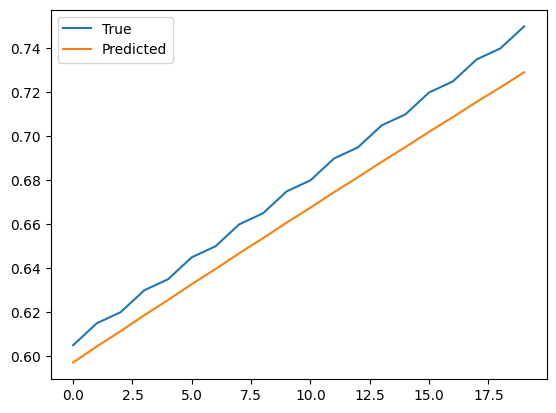

In [17]:
#evaluate the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()